# Gravity sparse inversion with constructor function

In [1]:
import discretize
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
from gravity import GravitySimulation
from simpeg.maps import IdentityMap
from simpeg.potential_fields.gravity import (
    Point,
    Simulation3DIntegral,
    SourceField,
    Survey,
)
from simpeg.utils import depth_weighting, model_builder

import inversion_ideas as ii

## Define synthetic data with two prisms

In [2]:
prisms = [
    (-60, -40, -10, 10, -70, -50),
    (40, 60, -10, 10, -70, -50),
]
densities = np.array([-200, 200])  # SI units

region = (-100, 100, -100, 100)
shape = (31, 31)
height = 0
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

In [3]:
gz = hm.prism_gravity(coordinates, prisms, densities, field="g_z")
gz *= -1  # Invert sign to work with upward component

# Add noise
stderr = vd.maxabs(gz) * 0.01
gz += np.random.default_rng(seed=51).normal(scale=stderr, size=gz.shape)

print(f"{stderr=}")

stderr=np.float64(2.5745854651805945e-05)


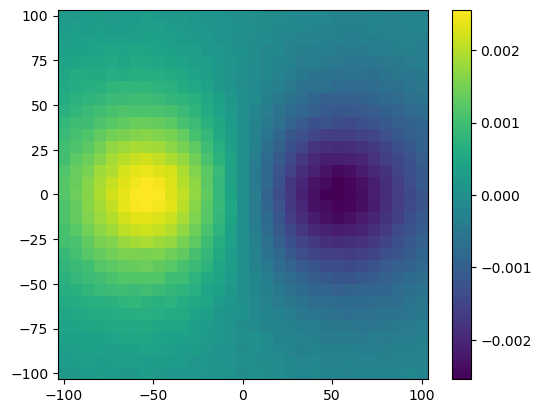

In [4]:
tmp = plt.pcolormesh(*coordinates[:2], gz)
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [5]:
gz.size

961

## Define SimPEG simulation

In [6]:
# h = [(5.0, 40)]
h = [(10.0, 20)]
mesh = discretize.TensorMesh(h=[h, h, h], origin="CCN")
mesh

TensorMesh: 8,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     20       -100.00        100.00     10.00     10.00    1.00
   y     20       -100.00        100.00     10.00     10.00    1.00
   z     20       -200.00          0.00     10.00     10.00    1.00

In [7]:
locations = np.vstack(tuple(c.ravel() for c in coordinates)).T
receivers = Point(locations, components="gz")
source = SourceField(receiver_list=[receivers])
survey = Survey(source)

In [8]:
simulation_simpeg = Simulation3DIntegral(mesh, survey=survey, rhoMap=IdentityMap(mesh))

In [9]:
def block_corners(prism):
    p0 = np.array([prism[0], prism[2], prism[4]])
    p1 = np.array([prism[1], prism[3], prism[5]])
    return p0, p1

In [10]:
model = np.zeros(mesh.n_cells)
densities_gcc = densities * 1e-3
print(densities_gcc)

for prism, density in zip(prisms, densities_gcc, strict=True):
    p0, p1 = block_corners(prism)
    model = model_builder.add_block(mesh.cell_centers, model, p0, p1, density)

[-0.2  0.2]


(<matplotlib.collections.QuadMesh at 0x7f58e8235e50>,)

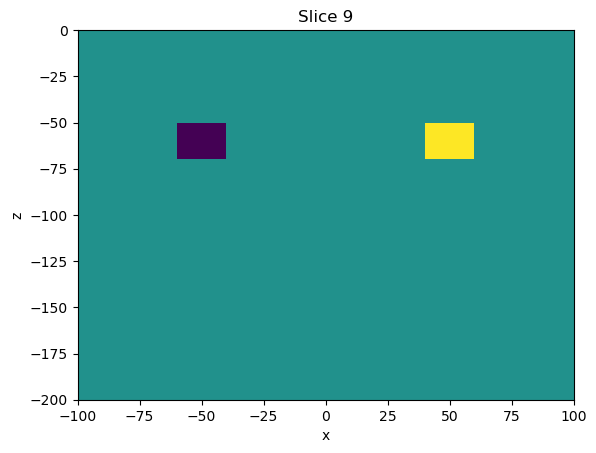

In [11]:
mesh.plot_slice(model, normal="Y", slice_loc=0)

In [12]:
dpred = simulation_simpeg.dpred(model)

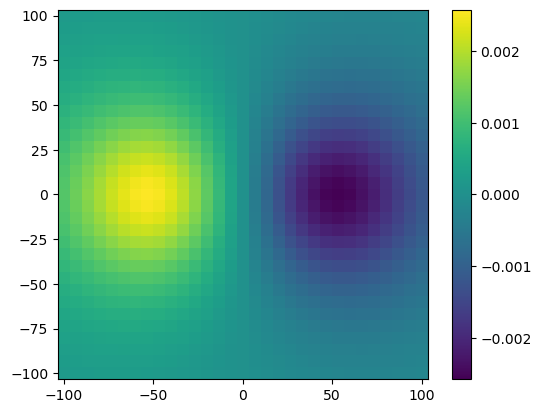

In [13]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

## Sparse gravity inversion

Wrap SimPEG's simulation into a child of the new `Simulation` class:

In [14]:
simulation = GravitySimulation(simulation_simpeg, jac_as_linop=False)

In [15]:
uncertainties = stderr * np.ones(gz.size)
data_misfit = ii.DataMisfit(gz.ravel(), uncertainties, simulation)

In [16]:
volume_weights = mesh.cell_volumes
depth_weights = depth_weighting(mesh, 0)
sparse_smallness = ii.SparseSmallness(
    n_params=simulation.n_params, 
    norm=1,
    model_previous=None,
    weights=volume_weights * depth_weights,
    irls=False, # Start with IRLS deactivated
)

In [17]:
initial_model = np.zeros(simulation.n_params)
minimizer = ii.ConjugateGradient()

sparse_inversion = ii.create_sparse_inversion(
    data_misfit,
    sparse_smallness,
    starting_beta=1e4,
    initial_model=initial_model,
    minimizer=minimizer,
    preconditioner="jacobi",
    max_iterations=100,
)

In [18]:
model = sparse_inversion.run()

Output()

INFO: 🎉 Inversion successfully finished due to stopping criteria.


In [19]:
sparse_inversion.stopping_criteria.info(model)

[x] ObjectiveChanged
├── Condition: |φ(m) - φ(m_prev)| <= max(|φ(m_prev)| * rtol, atol)
├── |φ(m) - φ(m_prev)| = 8.09e+01
├── |φ(m_prev)|        = 8.11e+04
├── rtol               = 1.00e-03
└── atol               = 0.00e+00

In [20]:
log = sparse_inversion.log.to_pandas()
log

,beta,phi_d,phi_m,beta * phi_m,phi,chi,IRLS,IRLS threshold,model_norm_relative_diff
iter,,,,,,,,,
0,10000.000000,1.667546e+06,0.000000,0.000000,1.667546e+06,1735.219131,inactive,1.000000e-08,NaN
1,10000.000000,4.389532e+05,38.478043,384780.425320,8.237336e+05,456.767118,inactive,1.000000e-08,inf
2,5000.000000,2.329218e+05,67.438364,337191.817628,5.701136e+05,242.374414,inactive,1.000000e-08,0.752645
3,2500.000000,1.107991e+05,101.489971,253724.928380,3.645240e+05,115.295649,inactive,1.000000e-08,0.504929
4,1250.000000,4.697145e+04,136.833740,171042.175052,2.180136e+05,48.877681,inactive,1.000000e-08,0.348249
...,...,...,...,...,...,...,...,...,...
69,0.012823,9.178579e+02,81357.064544,1043.258542,1.961116e+03,0.955107,active,6.735385e-07,0.001302
70,0.012823,9.180282e+02,81258.230295,1041.991170,1.960019e+03,0.955284,active,5.388308e-07,0.001215
71,0.012823,9.181852e+02,81165.956205,1040.807920,1.958993e+03,0.955448,active,4.310646e-07,0.001136


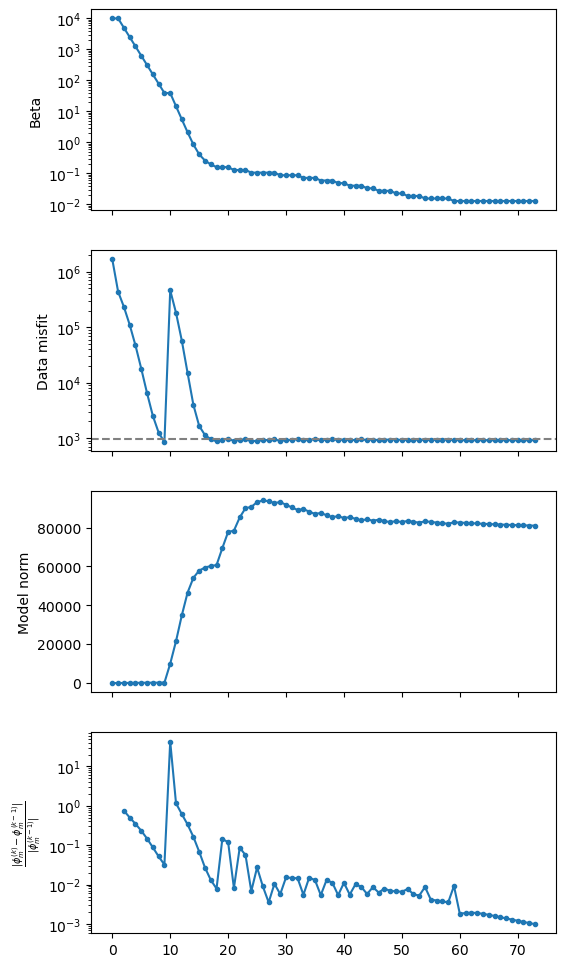

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6, 12))
axes[0].plot(log.index, log.beta, ".-")
axes[0].set_yscale("log")
axes[0].set_ylabel("Beta")

axes[1].plot(log.index, log.phi_d, ".-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(log.index, log.phi_m, ".-")
axes[2].set_ylabel("Model norm")

axes[3].plot(log.index, log.model_norm_relative_diff, ".-")
axes[3].set_ylabel(r"$\frac{ |\phi_m^{(k)} - \phi_m^{(k-1)}| }{ |\phi_m^{(k-1)}| }$")
axes[3].set_yscale("log")

plt.show()

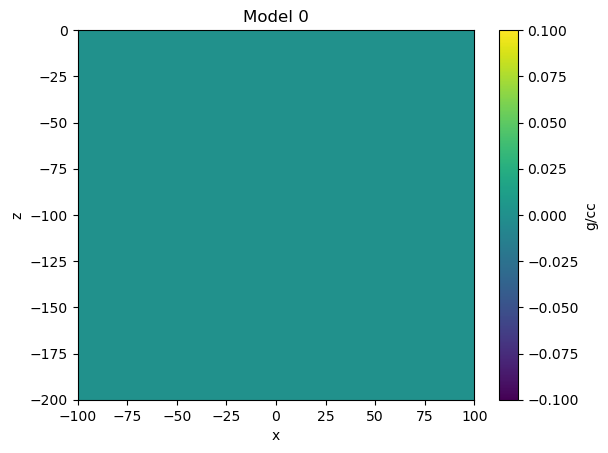

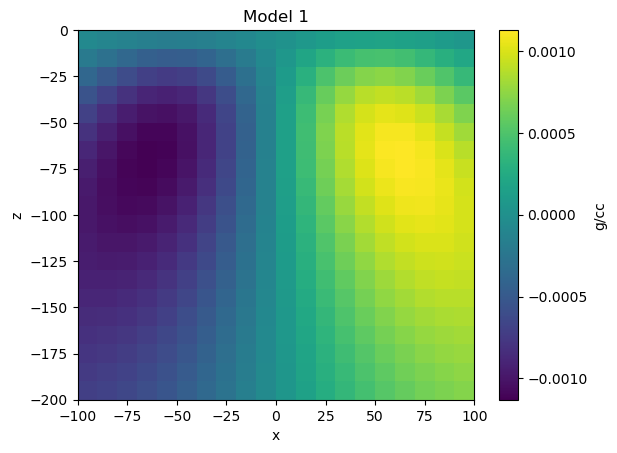

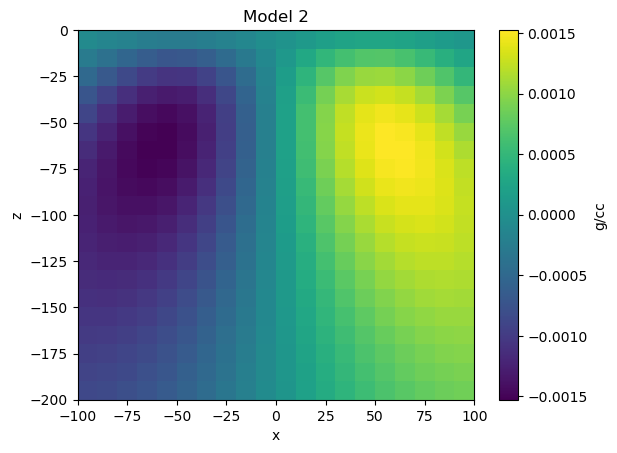

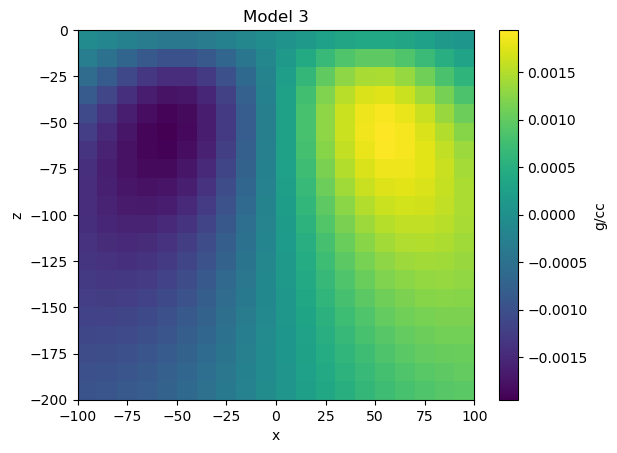

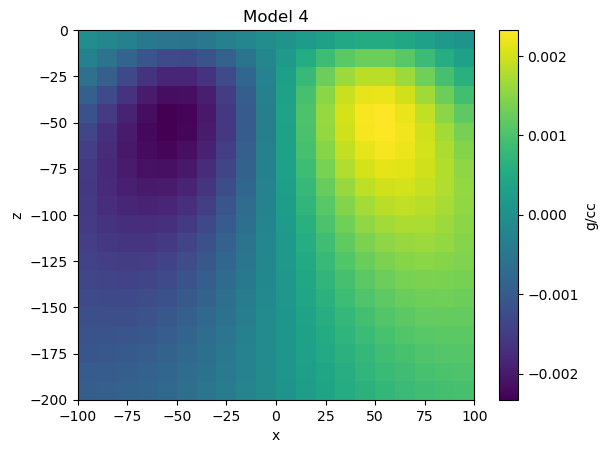

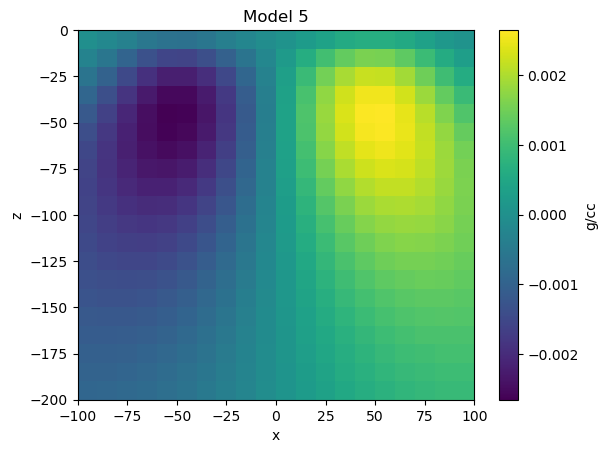

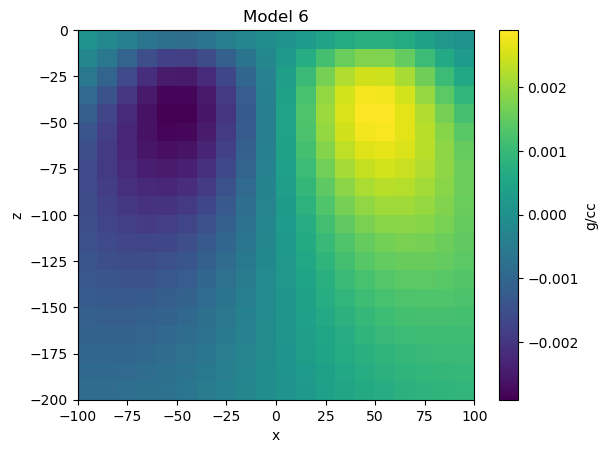

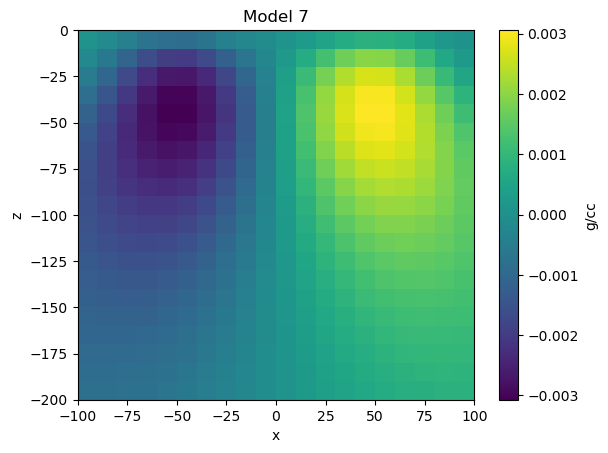

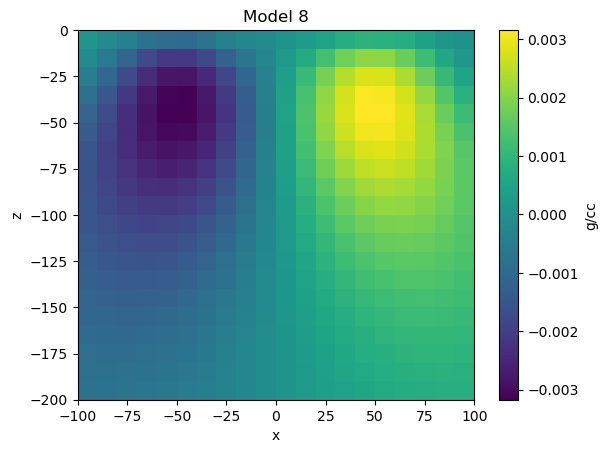

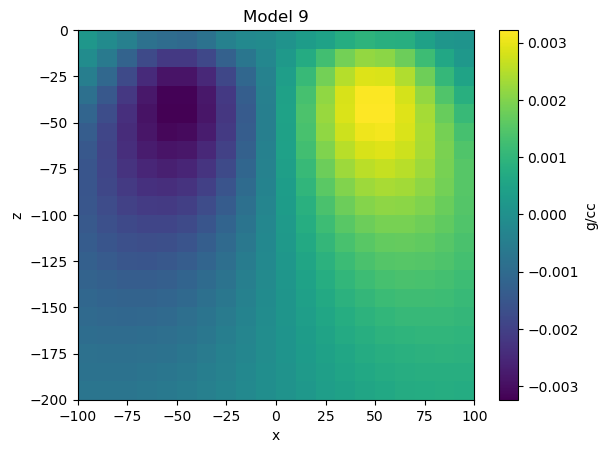

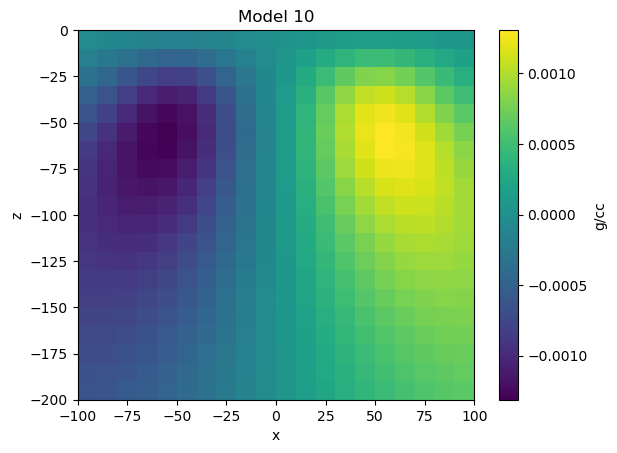

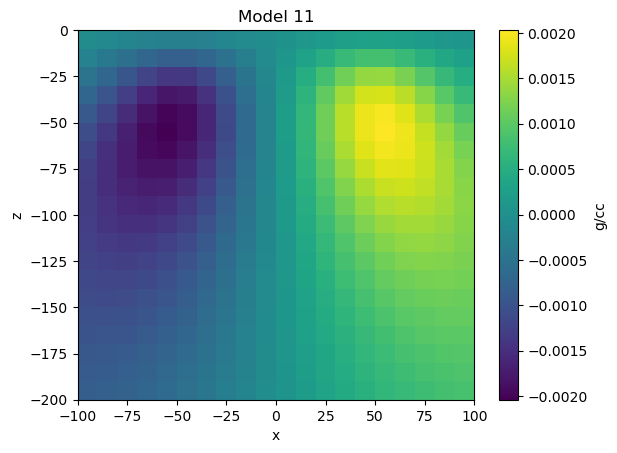

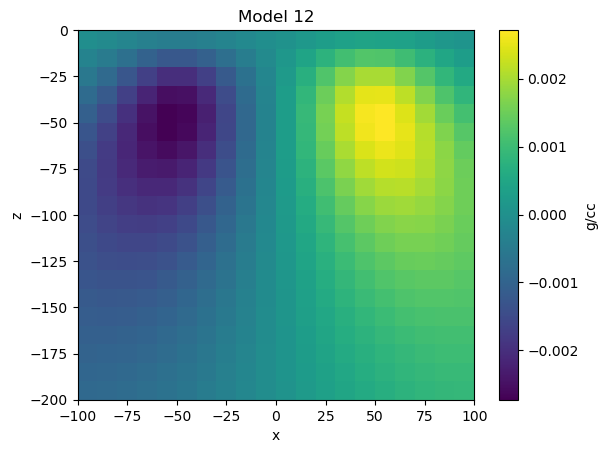

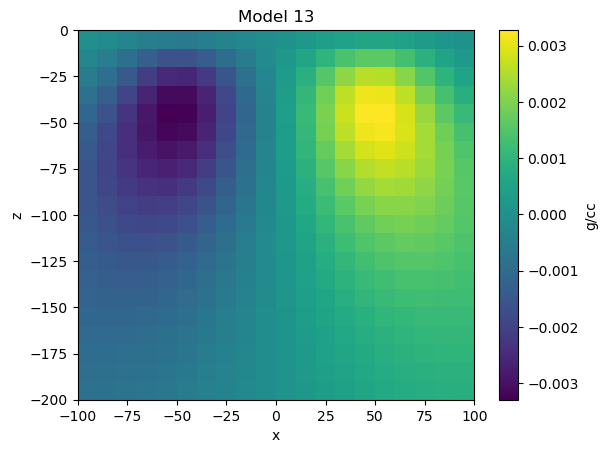

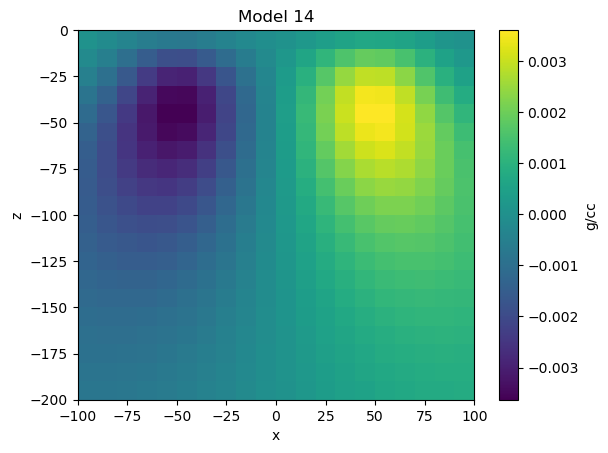

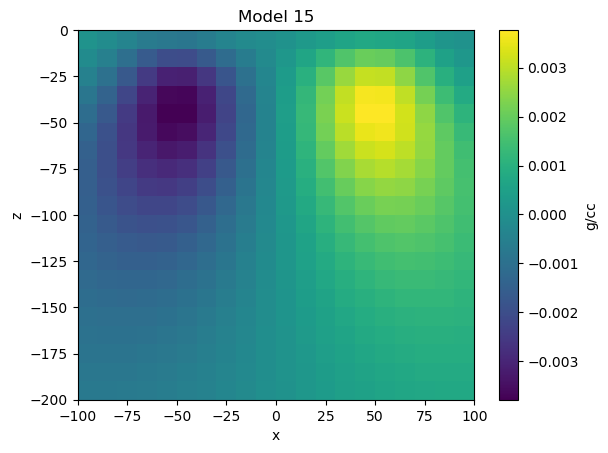

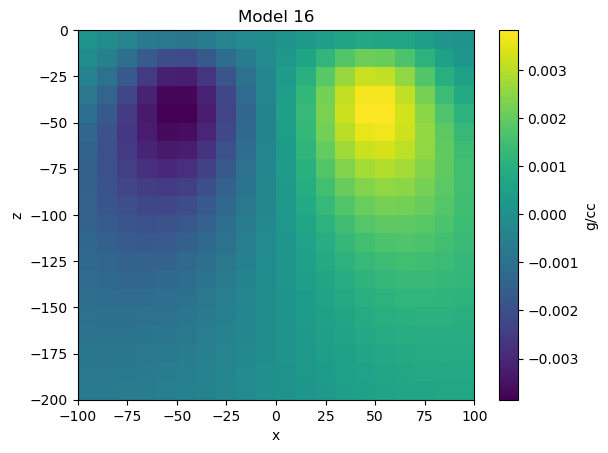

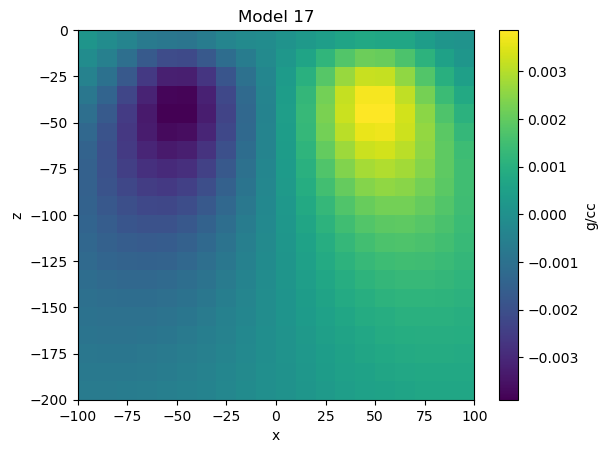

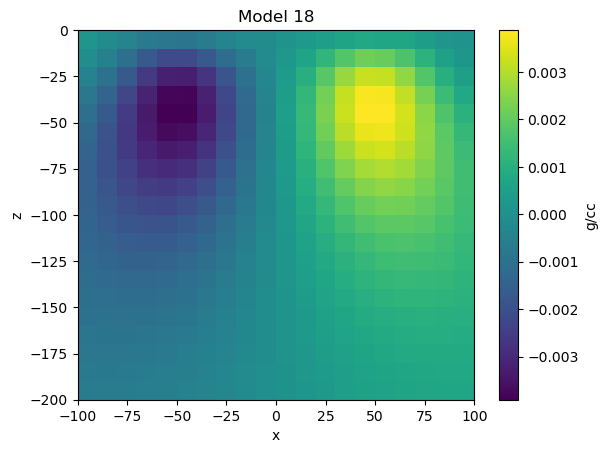

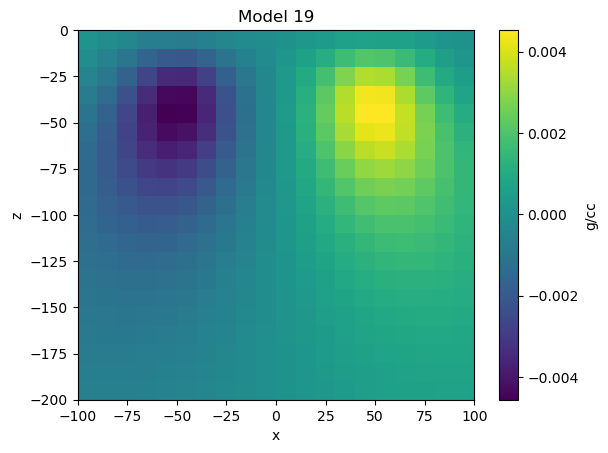

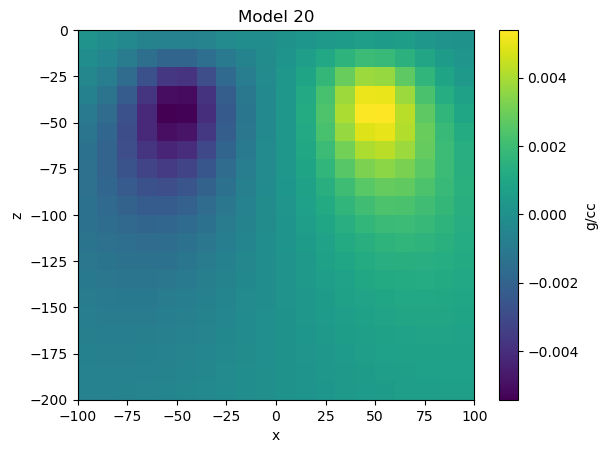

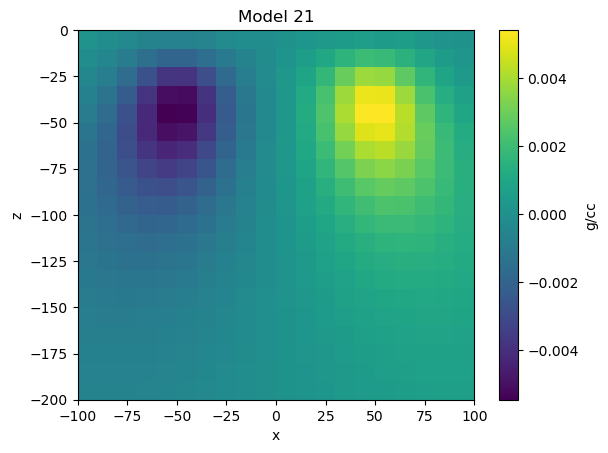

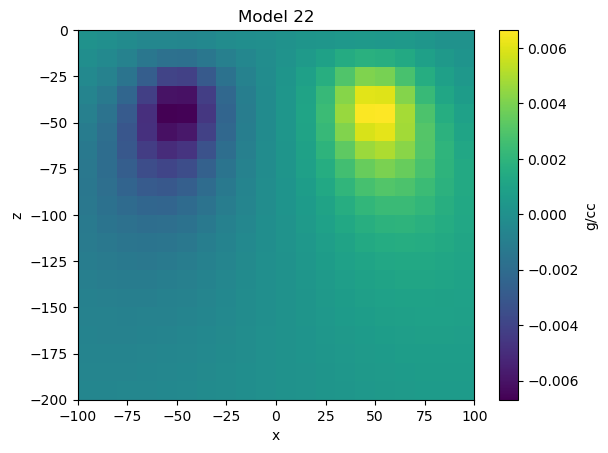

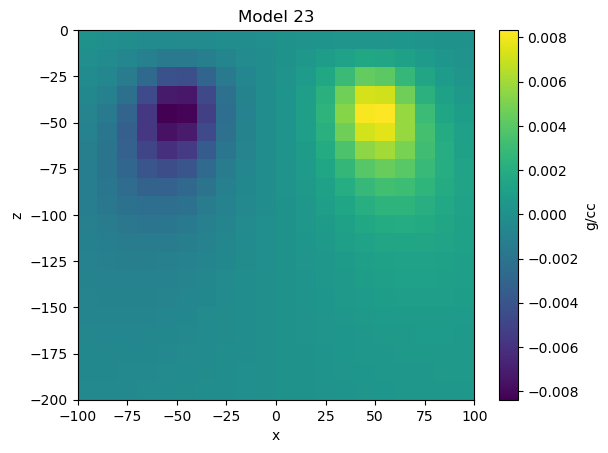

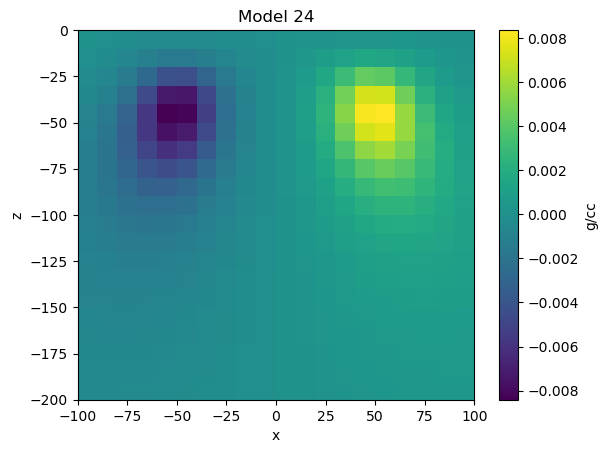

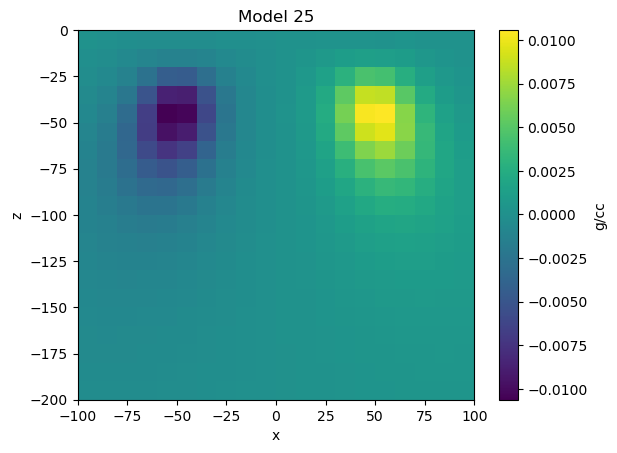

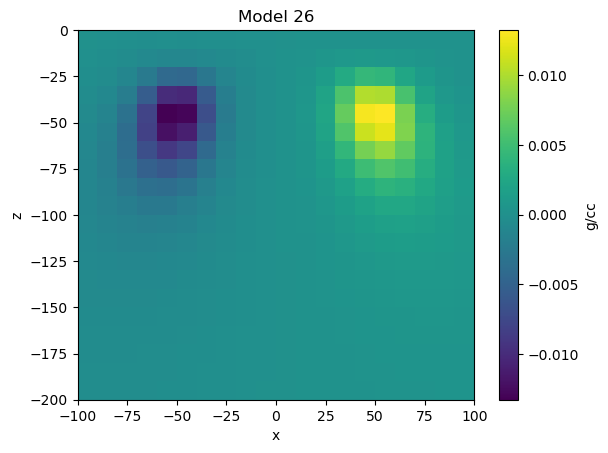

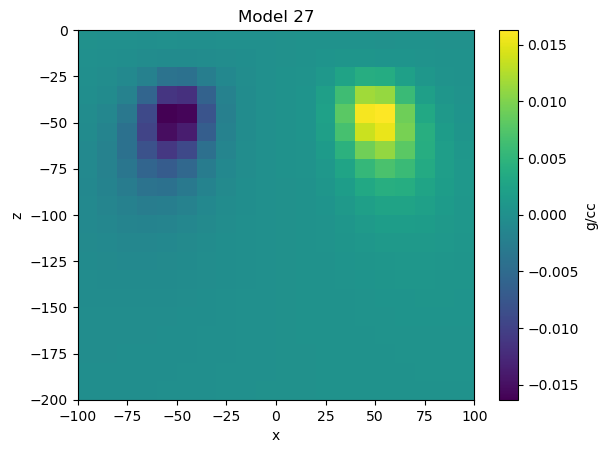

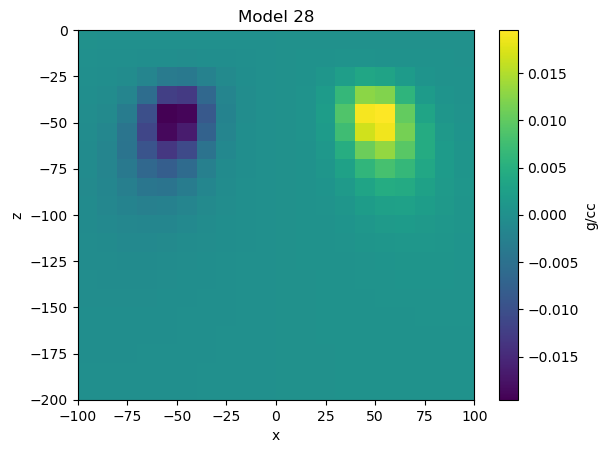

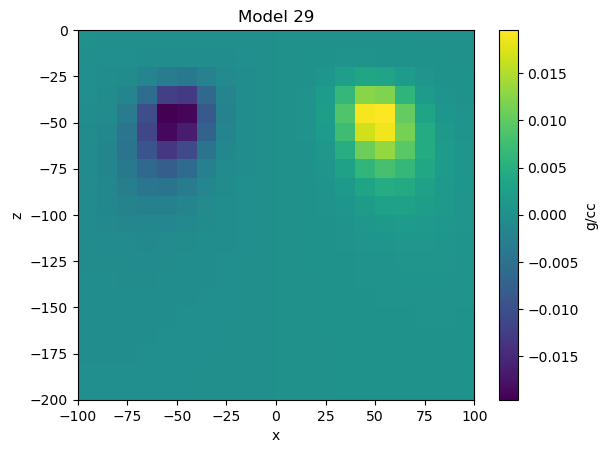

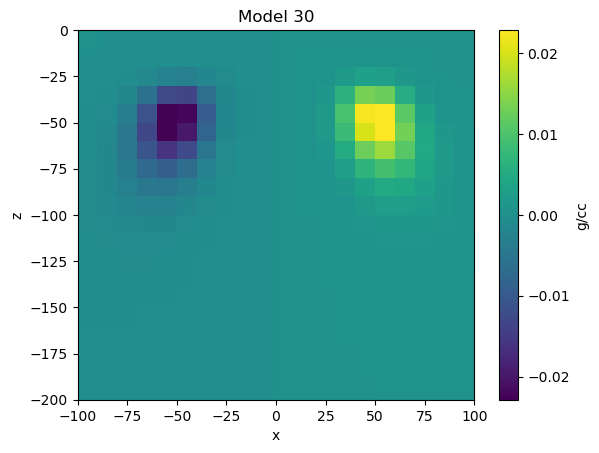

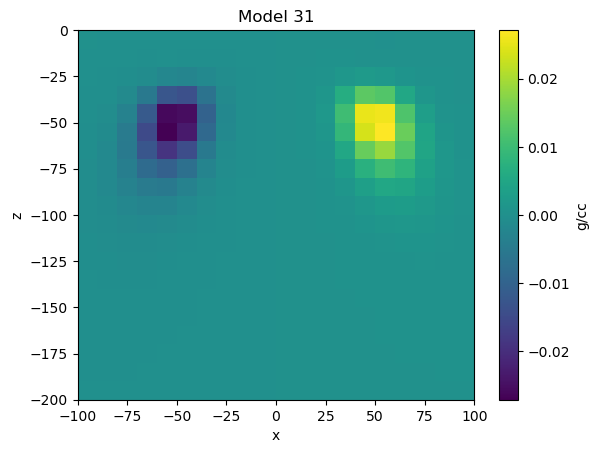

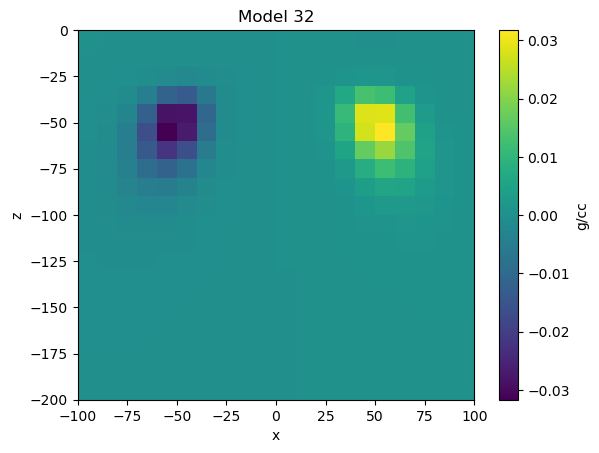

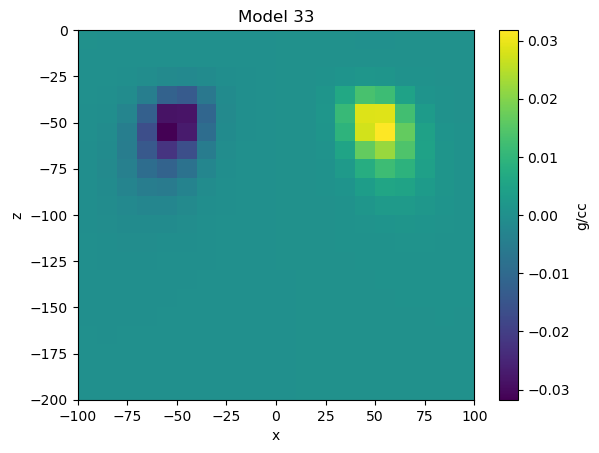

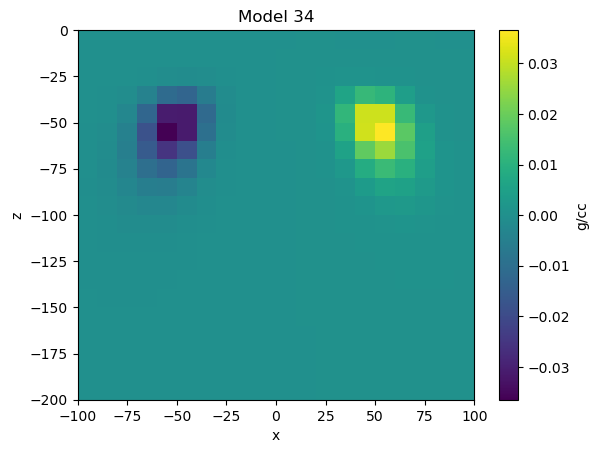

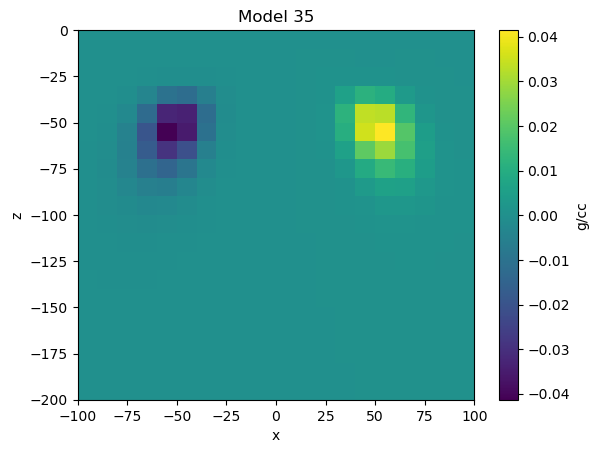

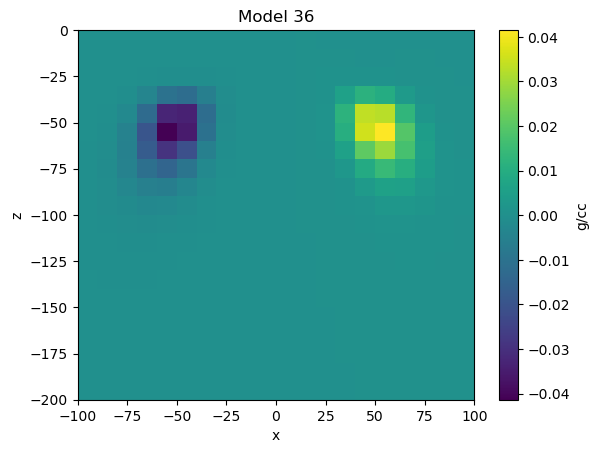

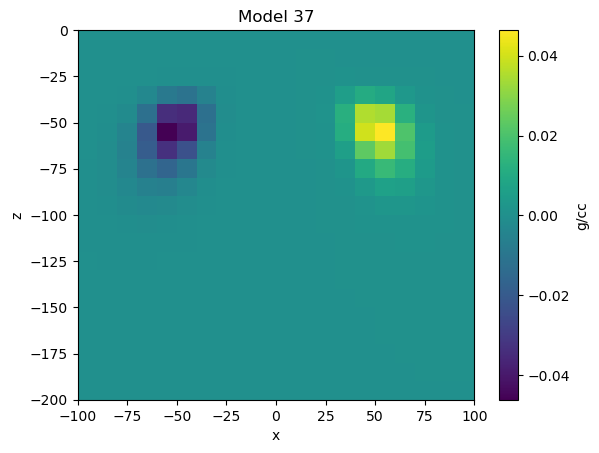

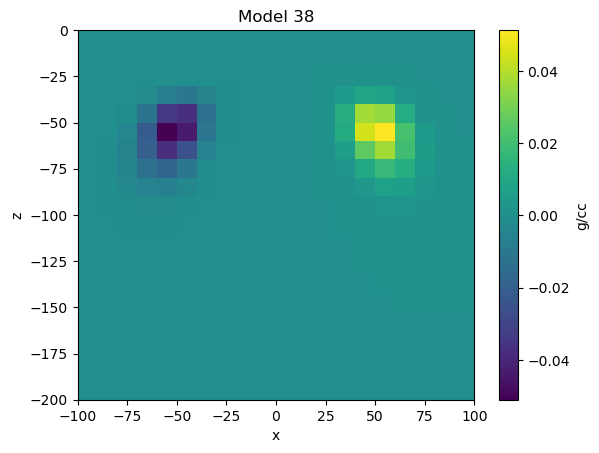

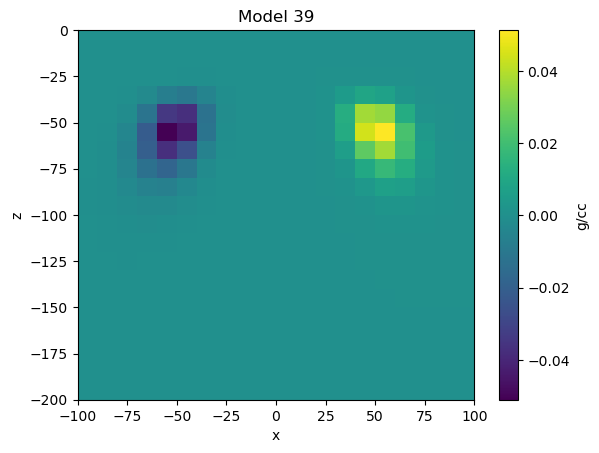

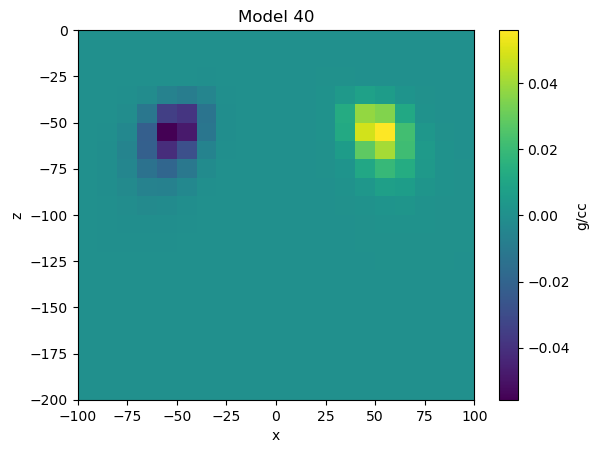

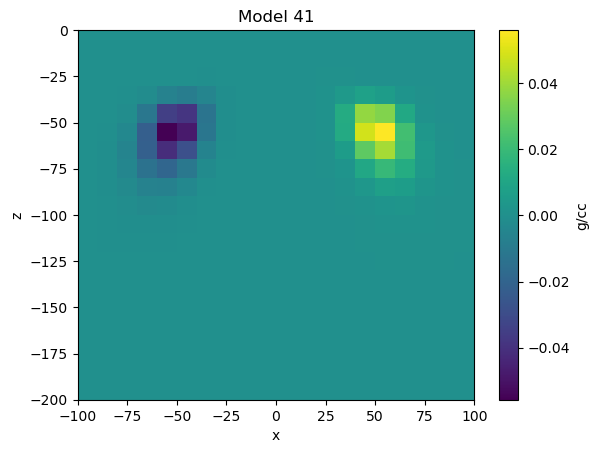

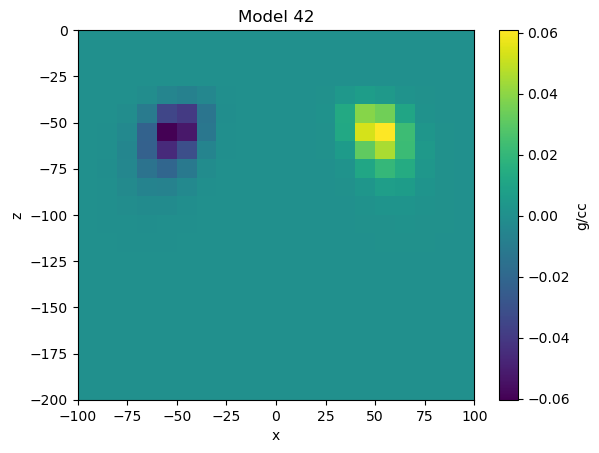

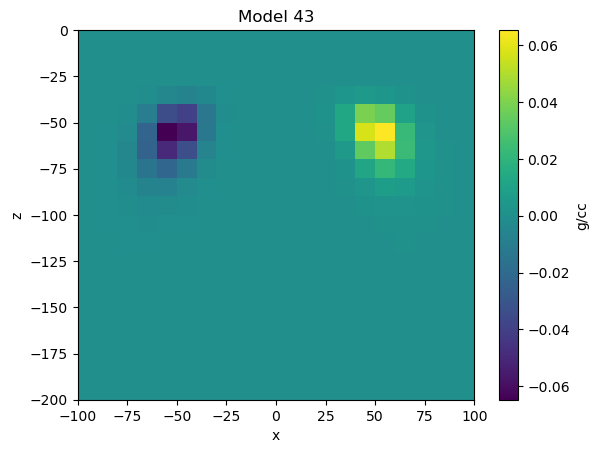

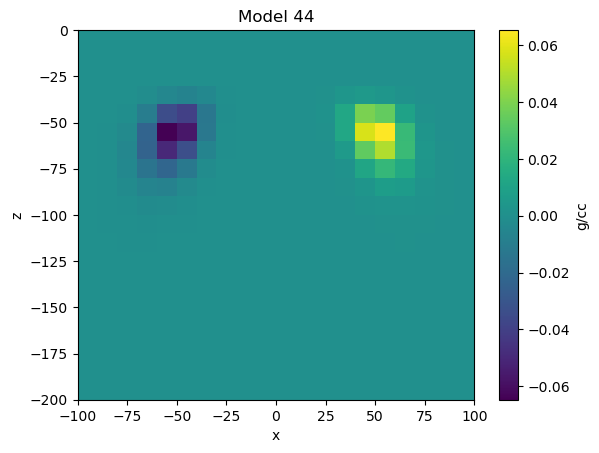

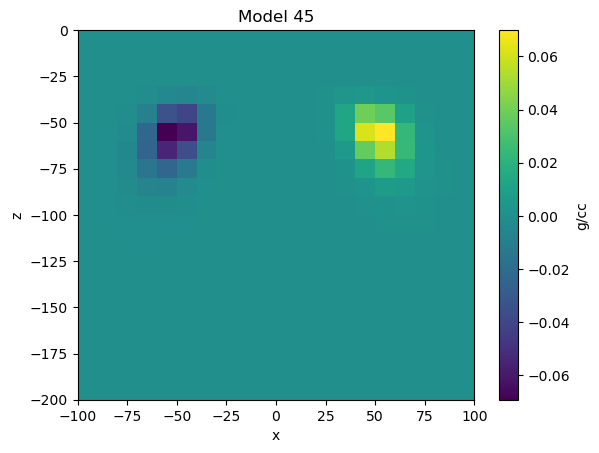

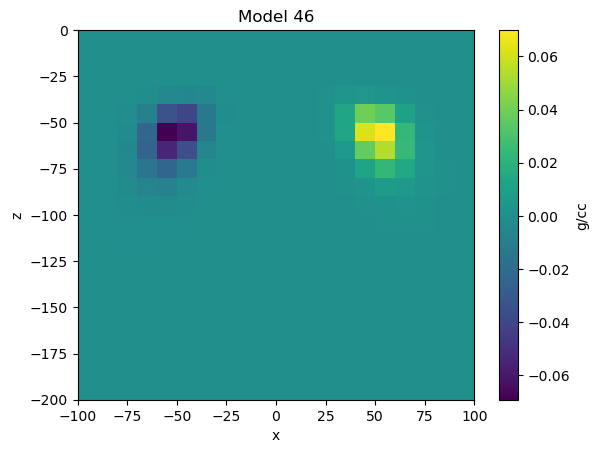

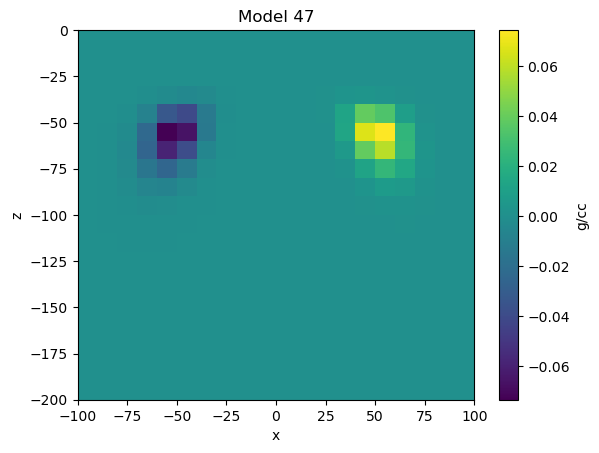

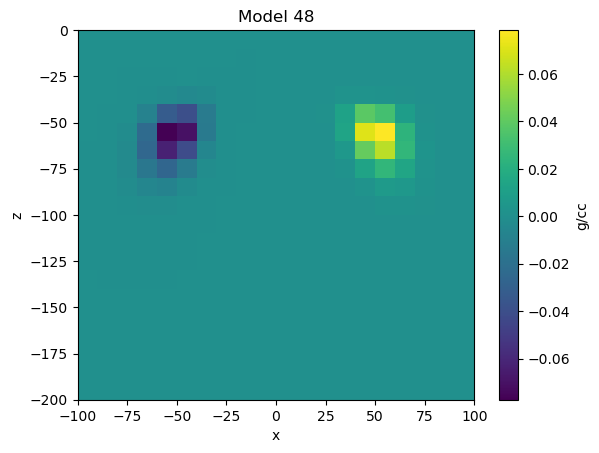

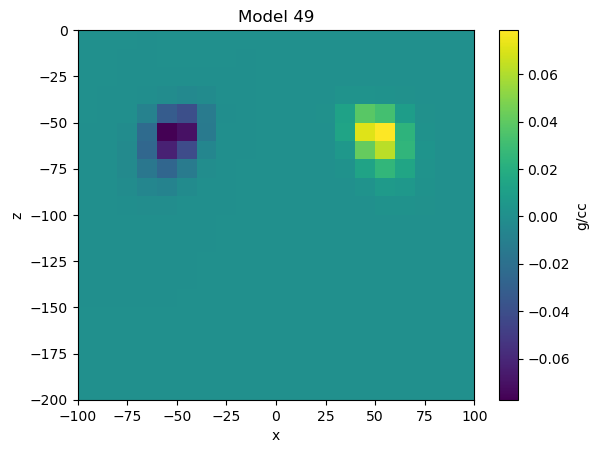

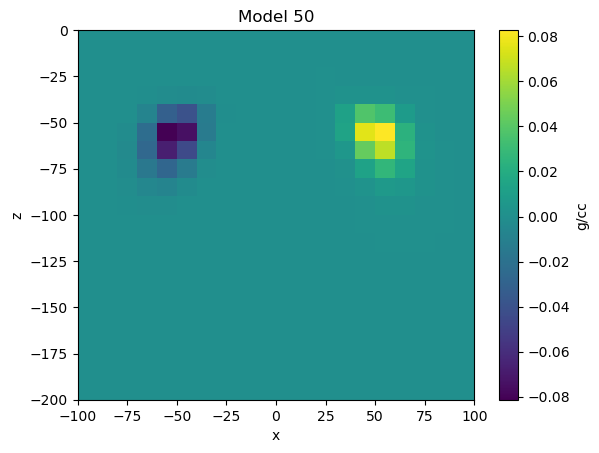

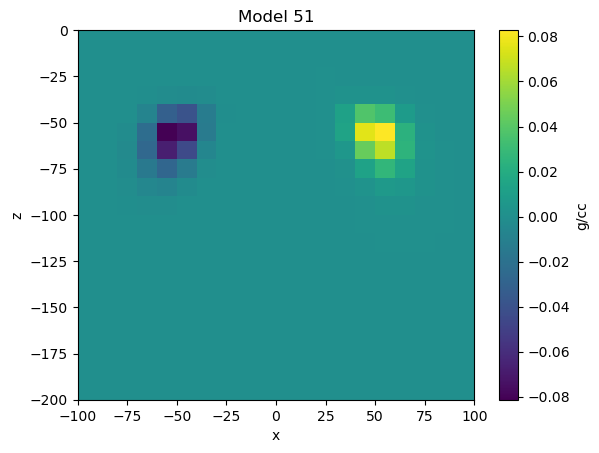

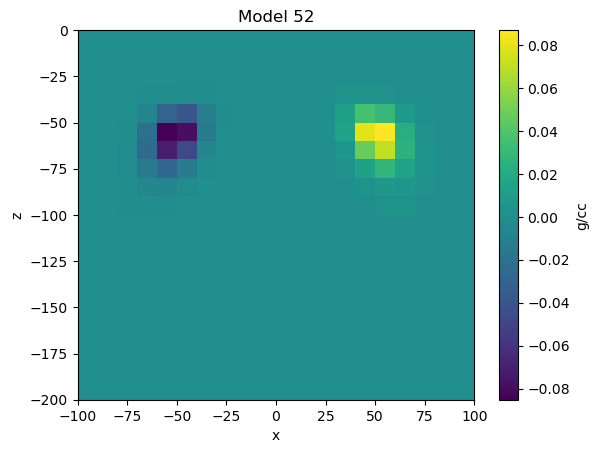

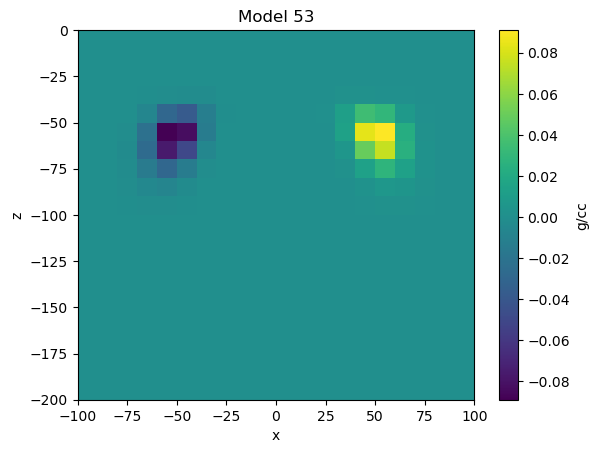

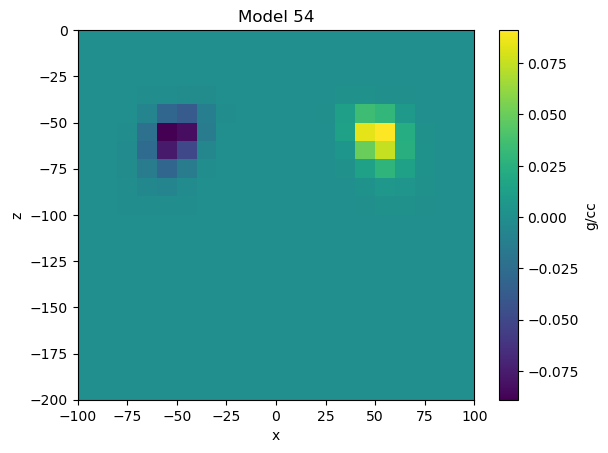

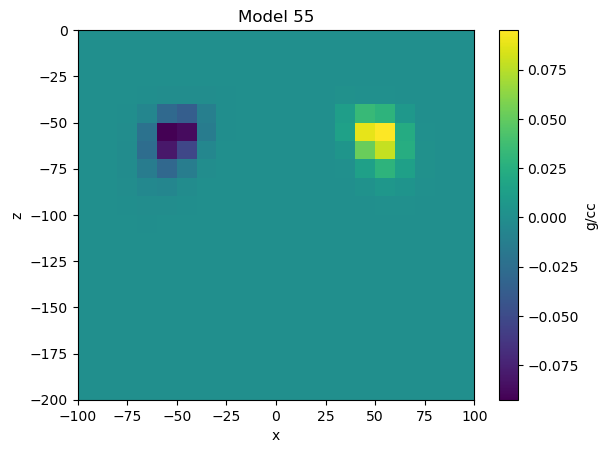

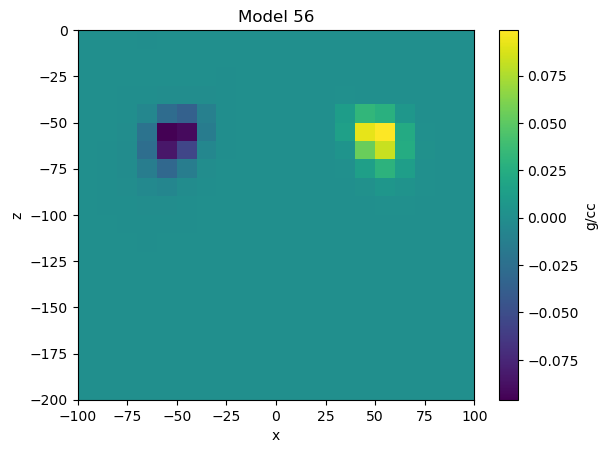

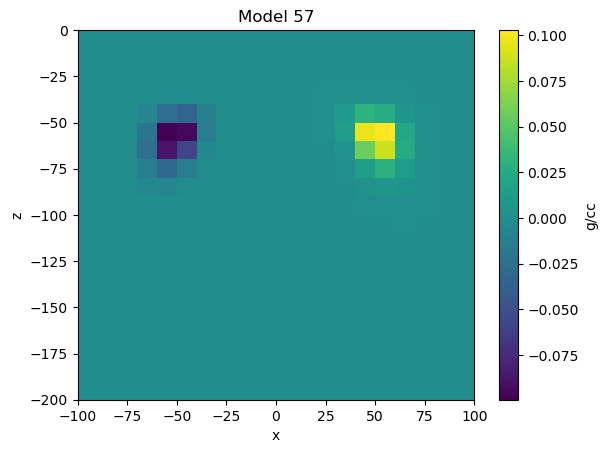

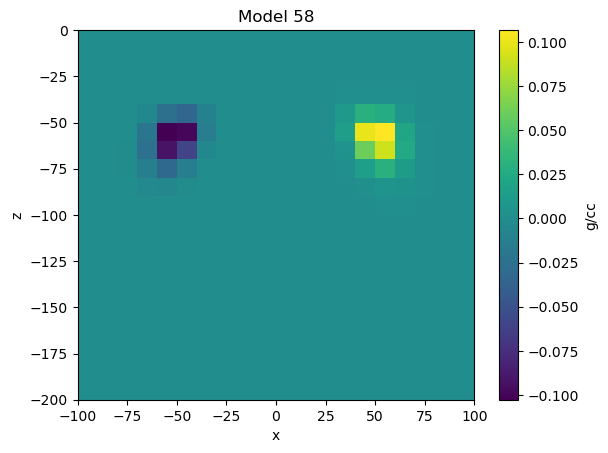

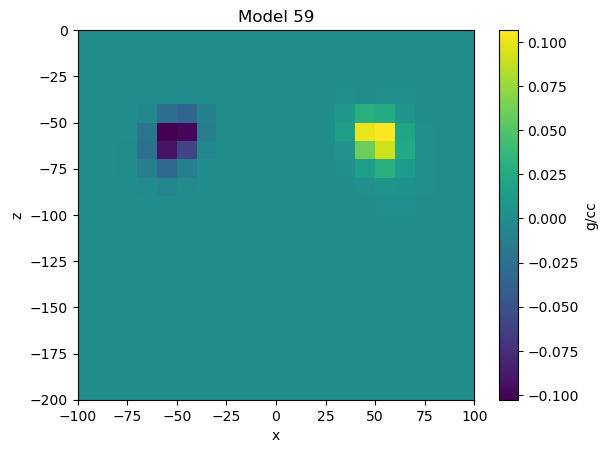

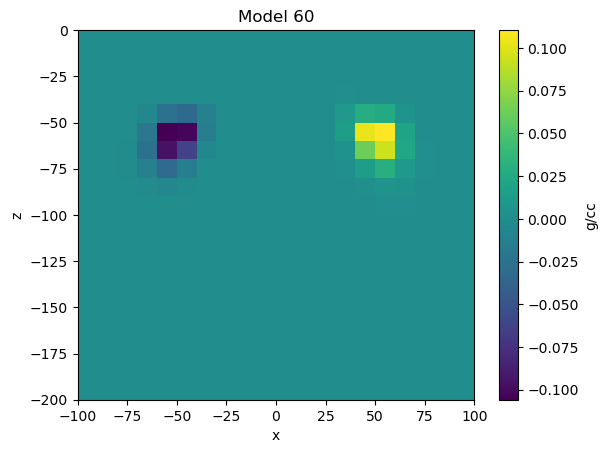

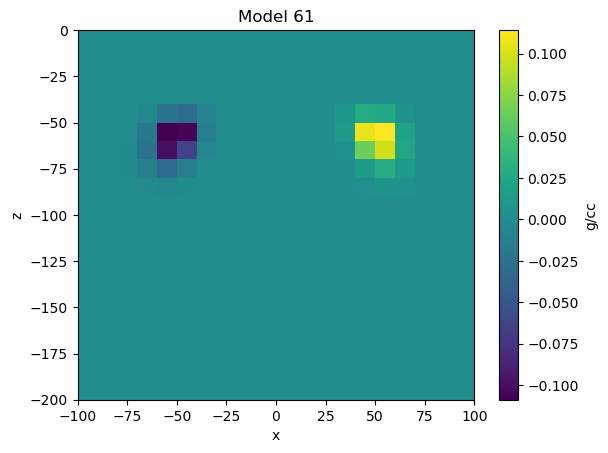

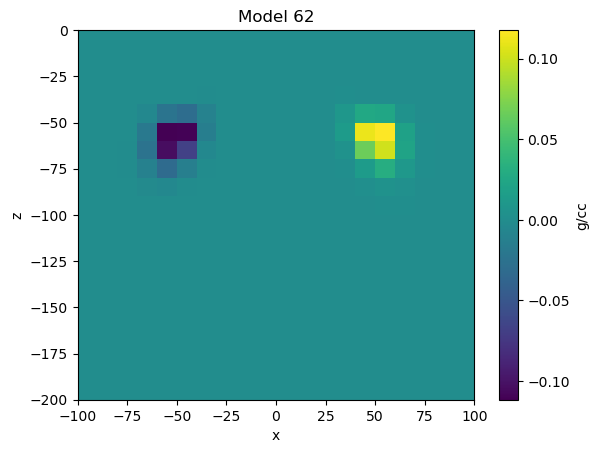

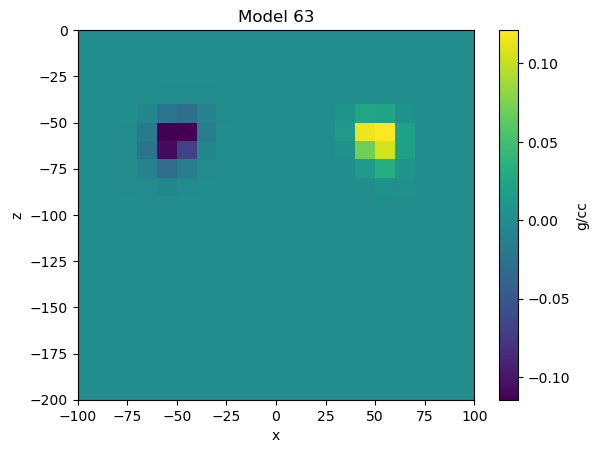

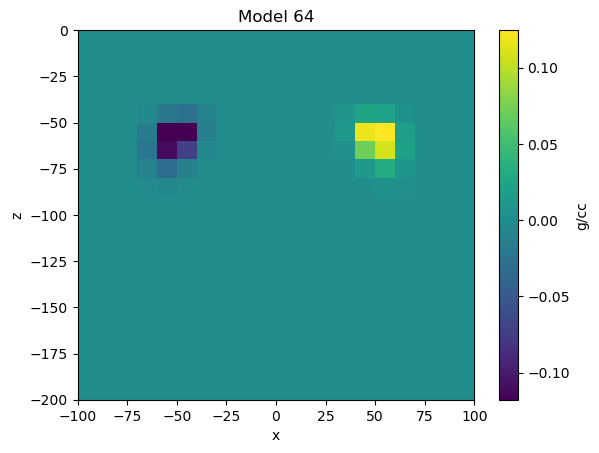

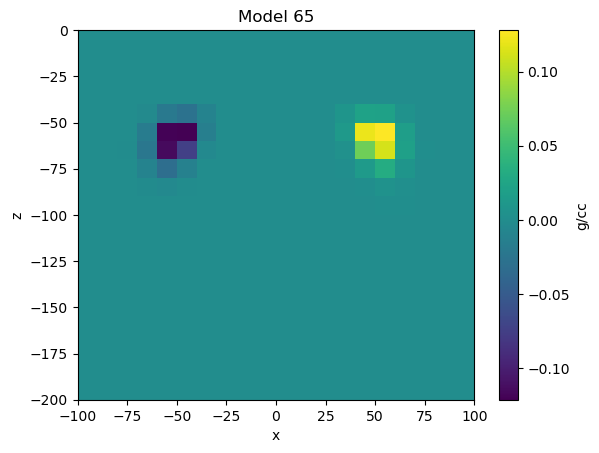

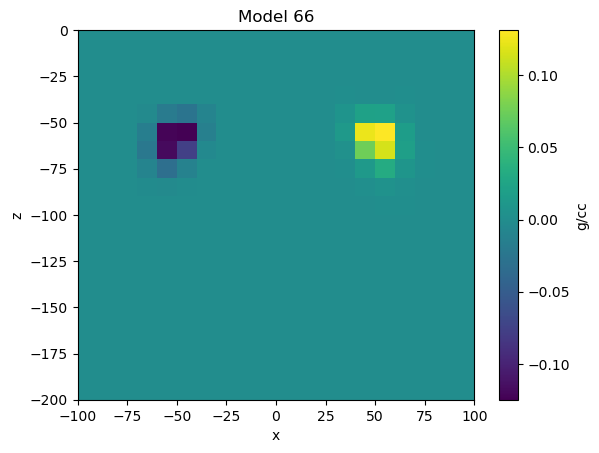

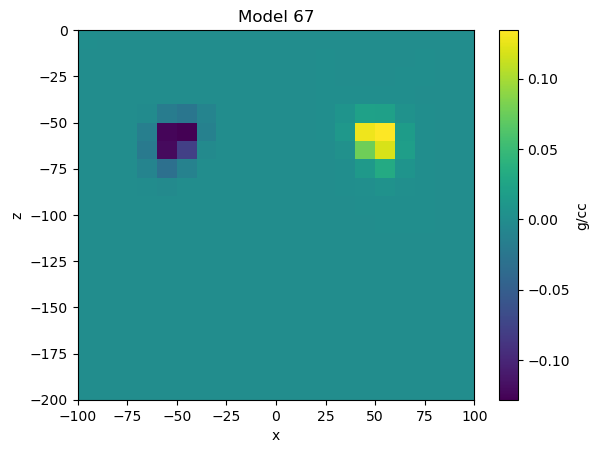

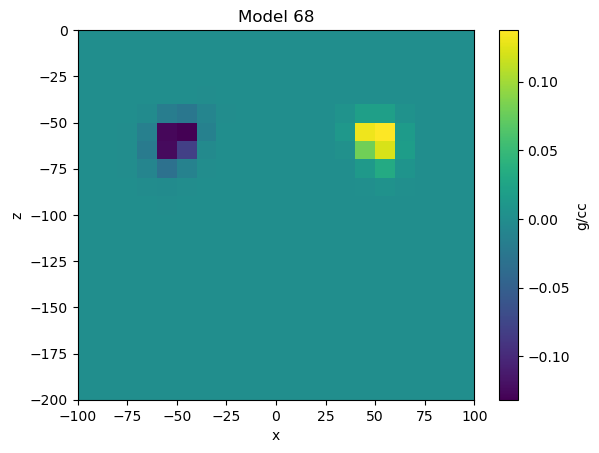

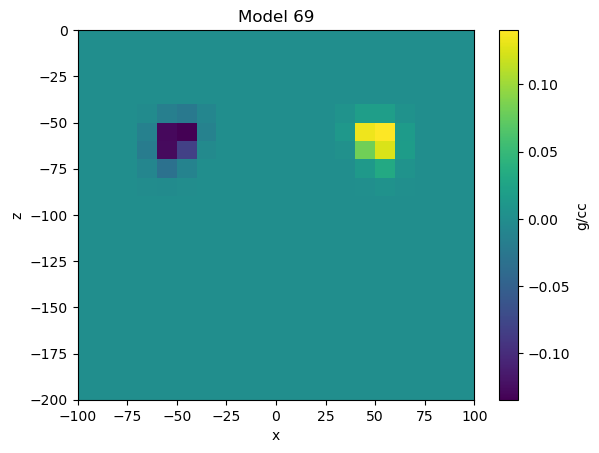

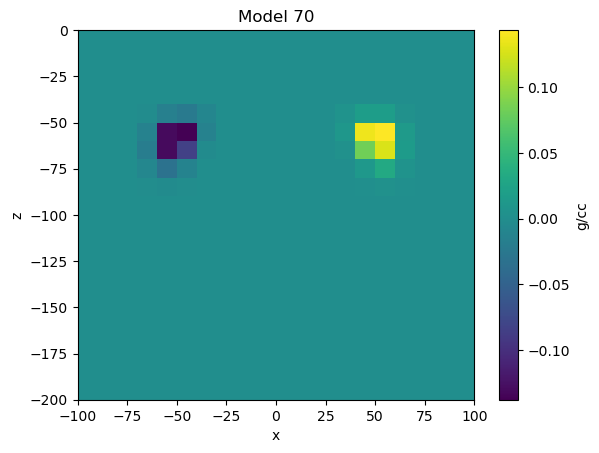

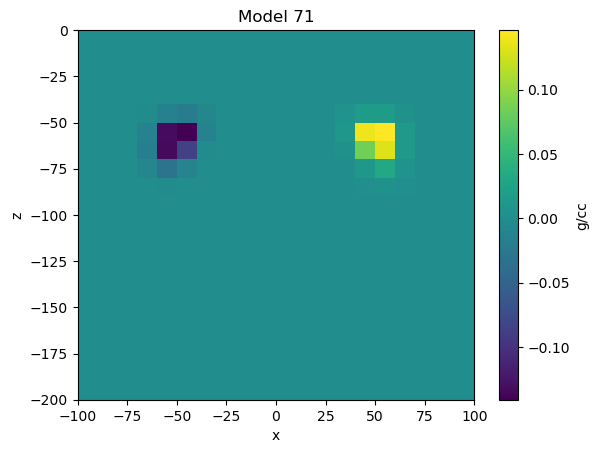

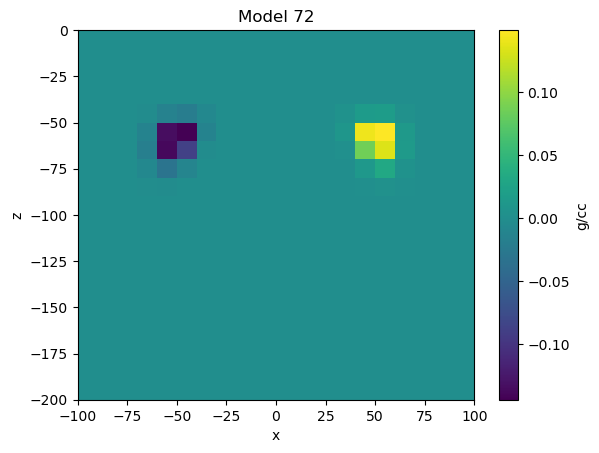

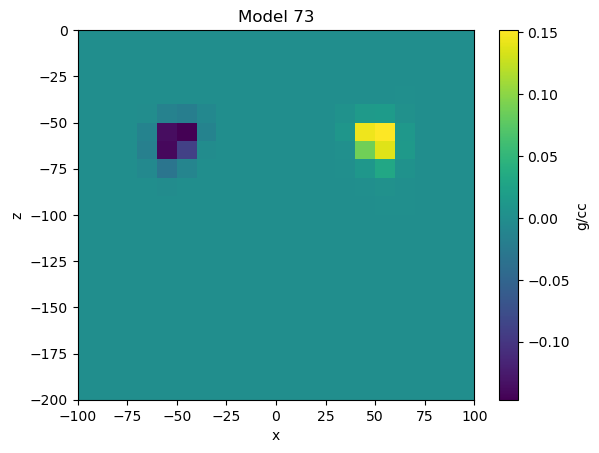

In [22]:
for i, model in enumerate(sparse_inversion.models):
    (tmp,) = mesh.plot_slice(model, normal="Y", slice_loc=0)
    plt.colorbar(tmp, label="g/cc")
    plt.title(f"Model {i}")
    plt.show()